In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact
%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score,f1_score, precision_recall_curve,average_precision_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from livelossplot import PlotLossesKerasTF

In [53]:
df = pd.read_csv("c:/users/asus/Desktop/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.9,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112542.6,0
2,3,15619304,Onio,502,France,Female,42,8,159660.8,3,1,0,113931.6,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.8,1,1,1,79084.1,0


## Exploratory Data Analysis and Visualization

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [55]:
df.shape

(10000, 14)

In [56]:
df.isnull().sum().any()

False

In [57]:
df.duplicated().sum() 

0

In [58]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5000.5,2886.9,1.0,2500.8,5000.5,7500.2,10000.0
CustomerId,10000.0,15690940.6,71936.2,15565701.0,15628528.2,15690738.0,15753233.8,15815690.0
CreditScore,10000.0,650.5,96.7,350.0,584.0,652.0,718.0,850.0
Age,10000.0,38.9,10.5,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,5.0,2.9,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,76485.9,62397.4,0.0,0.0,97198.5,127644.2,250898.1
NumOfProducts,10000.0,1.5,0.6,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,0.7,0.5,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,0.5,0.5,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,100090.2,57510.5,11.6,51002.1,100193.9,149388.2,199992.5


In [59]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

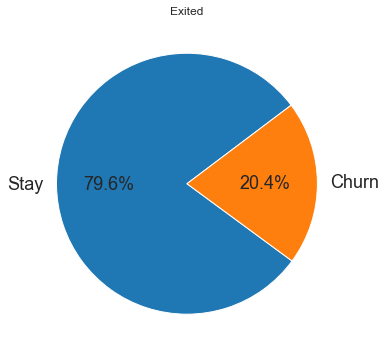

In [60]:
df.Exited.value_counts().plot.pie(autopct='%1.1f%%', 
                                  startangle=37, 
                                  fontsize=18, 
                                  labels=["Stay","Churn"], 
                                  ylabel='',
                                  title='Exited');

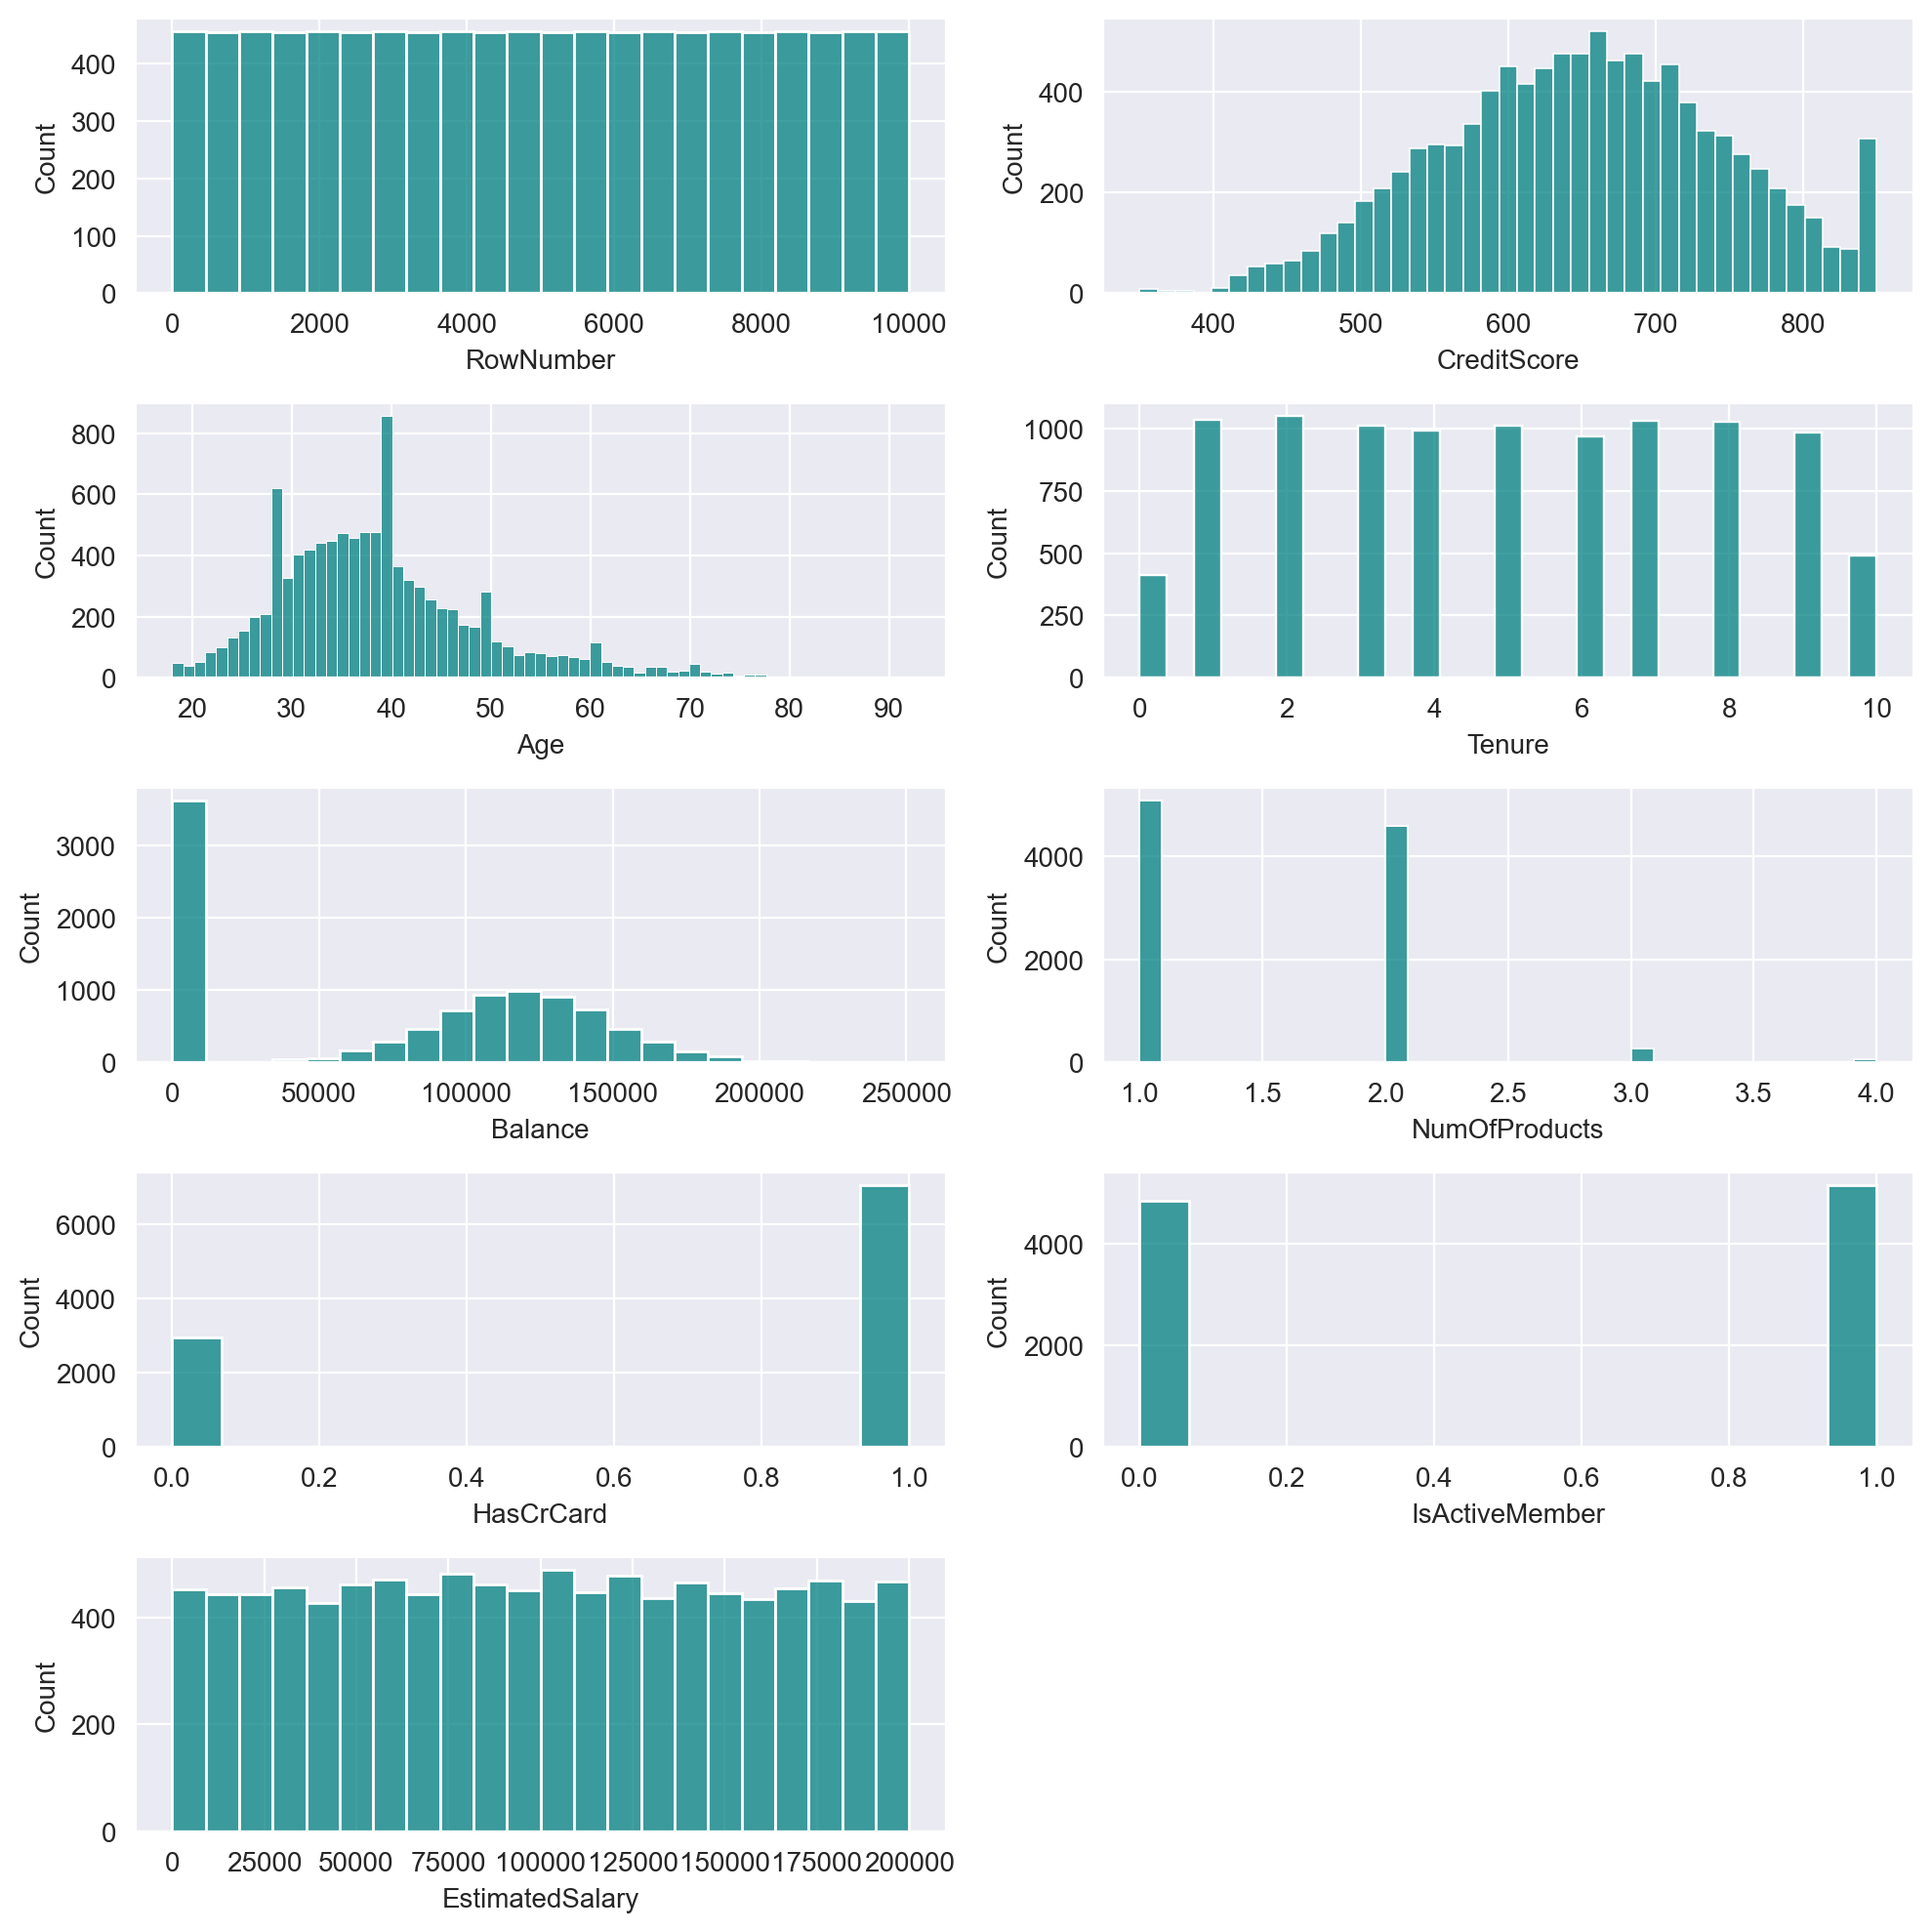

In [61]:
fig = plt.figure(figsize=(10,10), dpi=200)
for i, col in enumerate(df.select_dtypes(exclude="object").columns[:-1]):
        plt.subplot(5,2,i+1)
        sns.histplot(df[col], color="teal", )
plt.tight_layout();

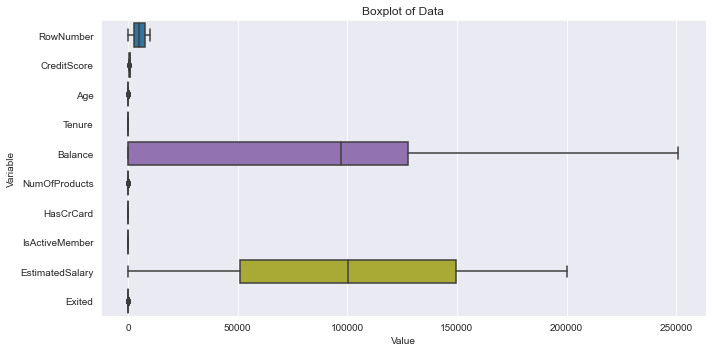

In [62]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, orient="h", linewidth=1.5)
plt.title("Boxplot of Data")
plt.ylabel("Variable")
plt.xlabel("Value")
plt.tight_layout()
plt.show()

In [63]:
def column_box(col):
    plt.figure(figsize=(10, 7))
    sns.boxplot(data=df,
                y=df[col],
                x=df["Exited"],
                palette='deep',
                saturation=1);


cols = df.select_dtypes(exclude="object").columns[:-1]
interact(column_box, col=cols);

interactive(children=(Dropdown(description='col', options=('RowNumber', 'CreditScore', 'Age', 'Tenure', 'Balan…

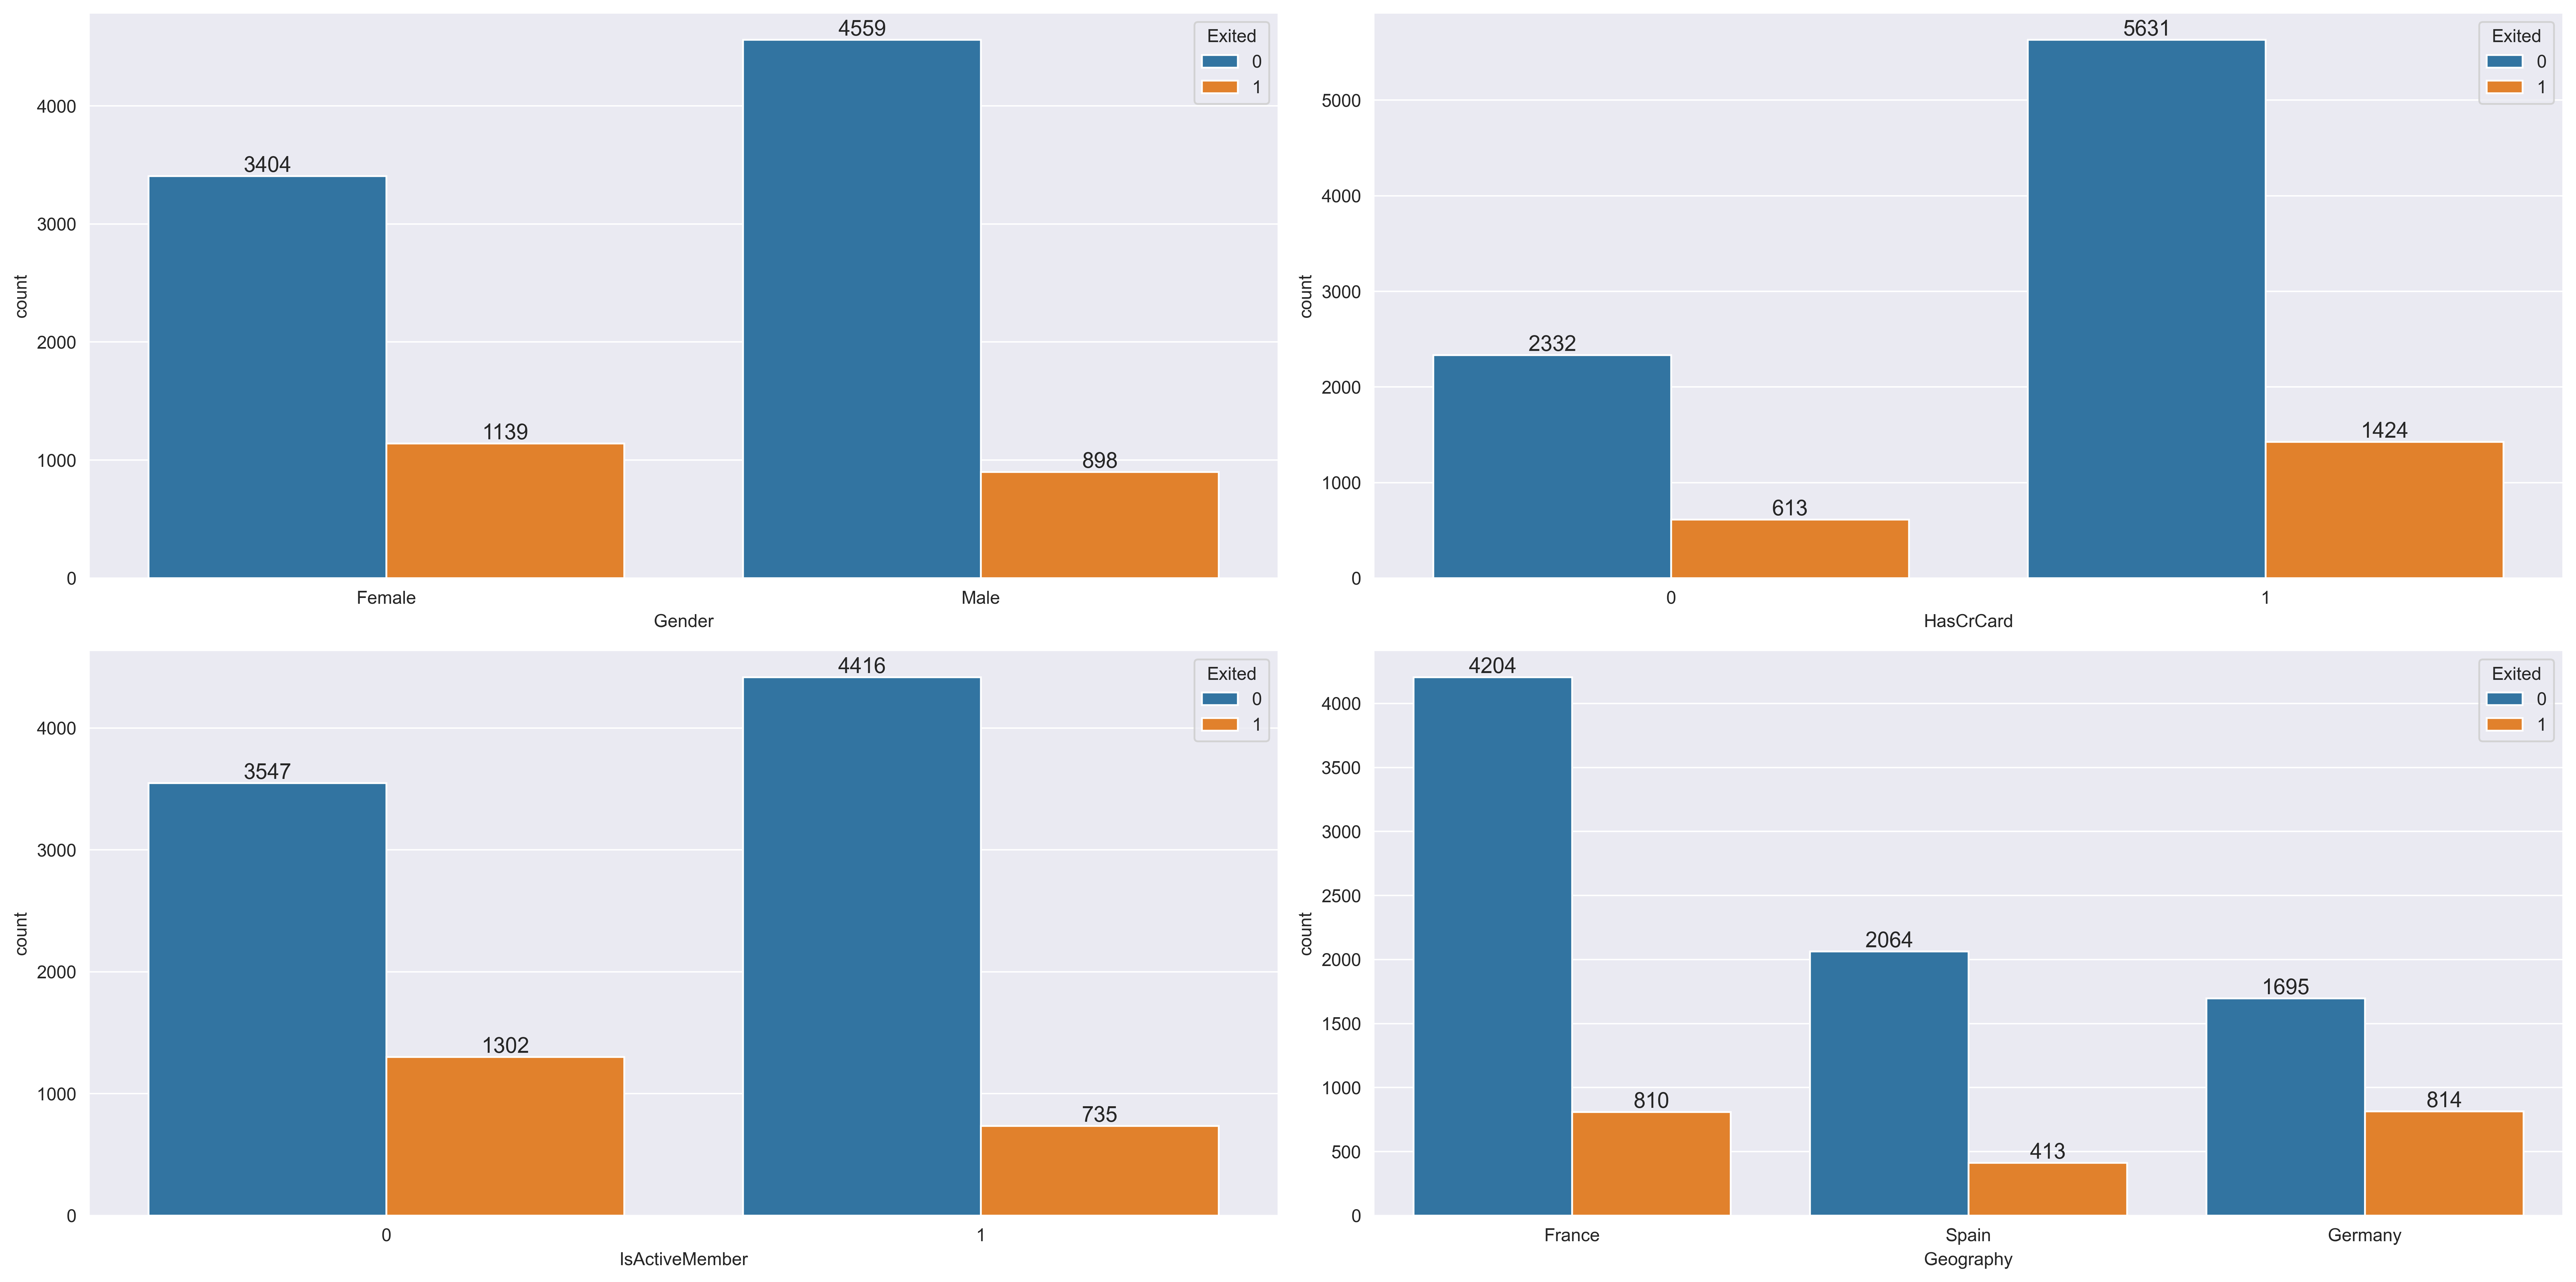

In [64]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(20, 10), dpi=400)
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    ax = sns.countplot(data=df, x=i, hue="Exited")
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.f', size=12)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Age', ylabel='count'>

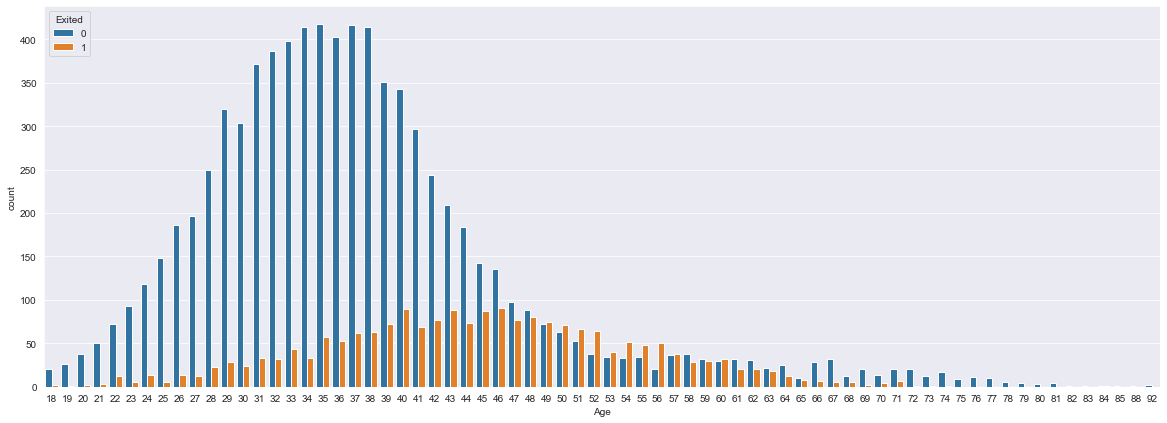

In [65]:
plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited)

## Feature engineering

In [66]:
df.CreditScore.describe()

count   10000.0
mean      650.5
std        96.7
min       350.0
25%       584.0
50%       652.0
75%       718.0
max       850.0
Name: CreditScore, dtype: float64

In [67]:
def credit_transformer(x, y):
    """to prodduce a new value by using credit score and has credit card"""

    if x < 350 and y == 0:
        return 0
    if x < 350 and y > 0:
        return 1
    if x < 718 and y == 0:
        return 2
    if x < 718 and y > 0:
        return 3
    else:
        return 4

In [68]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

[3, 2, 3, 2, 4, 3, 4, 3, 2, 3]

In [69]:
df.insert(10, "customer_value", customer_value)

In [70]:
df.customer_value

0       3
1       2
2       3
3       2
4       4
       ..
9995    4
9996    3
9997    2
9998    4
9999    4
Name: customer_value, Length: 10000, dtype: int64

<AxesSubplot:>

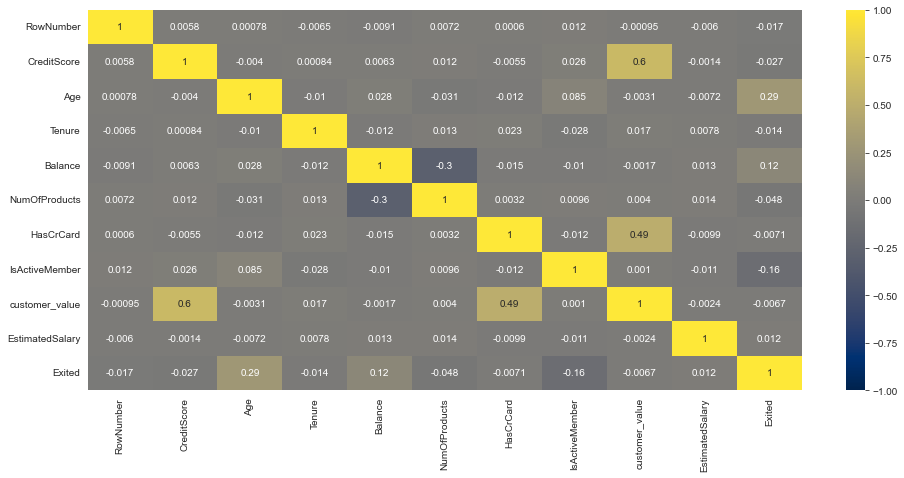

In [71]:
plt.figure(figsize=(16, 7))
sns.heatmap(df.corr(), annot=True, cmap='cividis', vmin=-1, vmax=1)

## Preprocessing of Data

In [72]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.15,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  test_size=0.1,
                                                  random_state=42)

In [74]:
cat_col = X_train.select_dtypes(include=['object', 'bool']).columns

encoder = OneHotEncoder(categories="auto",
                        sparse=False, 
                        #drop="first", 
                        handle_unknown="ignore")

In [75]:
transformers = [('cat', encoder, cat_col)]

col_transformer = ColumnTransformer(transformers=transformers,
                                    remainder='passthrough')

In [76]:
X_train = col_transformer.fit_transform(X_train)
X_val = col_transformer.transform(X_val)
X_test = col_transformer.transform(X_test)

In [77]:
scaler = MinMaxScaler()

In [78]:
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

### without class_weigth

In [79]:
tf.random.set_seed(42) 

model = Sequential() 

model.add(Dense(16, activation="relu")) 
model.add(Dense(8, activation="relu"))  
model.add(Dense(1, activation="sigmoid")) 

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"]) 

In [80]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=8,
                           restore_best_weights=True)

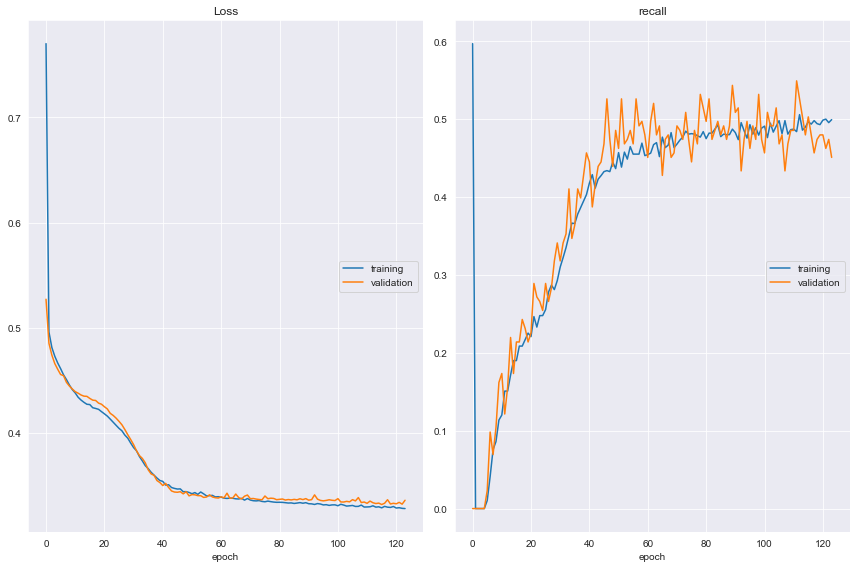

Loss
	training         	 (min:    0.328, max:    0.770, cur:    0.328)
	validation       	 (min:    0.332, max:    0.527, cur:    0.336)
recall
	training         	 (min:    0.000, max:    0.597, cur:    0.499)
	validation       	 (min:    0.000, max:    0.549, cur:    0.451)
60/60 [==============================] - 1s 14ms/step - loss: 0.3283 - recall: 0.4994 - val_loss: 0.3362 - val_recall: 0.4509
Epoch 124: early stopping


In [81]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_val, y_val),
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop, PlotLossesKerasTF()])

In [82]:
model.weights

[<tf.Variable 'dense_6/kernel:0' shape=(15, 16) dtype=float32, numpy=
 array([[ 0.2701958 ,  0.34084052, -0.18510643,  0.38216522, -0.1586262 ,
          0.23848358, -0.12760645,  0.02099434,  0.3875565 ,  0.31466976,
          0.32924992, -0.24619412, -0.14148581,  0.01553998,  0.30207774,
         -0.01502947],
        [-0.7752161 ,  0.43854624, -0.35838497, -0.11436609, -0.02982957,
         -0.22653928, -0.20167159, -0.04873615, -0.3496104 , -0.15949033,
          0.10022296,  0.14323205, -0.15431799, -0.04066093, -0.12302291,
         -0.06679983],
        [-0.17894174,  0.0133107 , -0.05448847,  0.31722927, -0.06855335,
         -0.06722631,  0.3695189 ,  0.04178512, -0.11537254,  0.05905747,
         -0.18346694,  0.00367353,  0.21675915, -0.11884327, -0.03940225,
          0.1216176 ],
        [ 0.32573947,  0.3238497 , -0.3623048 ,  0.21180876,  0.10039977,
         -0.00409013,  0.17047703,  0.20406495, -0.23009154,  0.10662352,
         -0.08369438,  0.01457092,  0.02134444,

In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                256       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

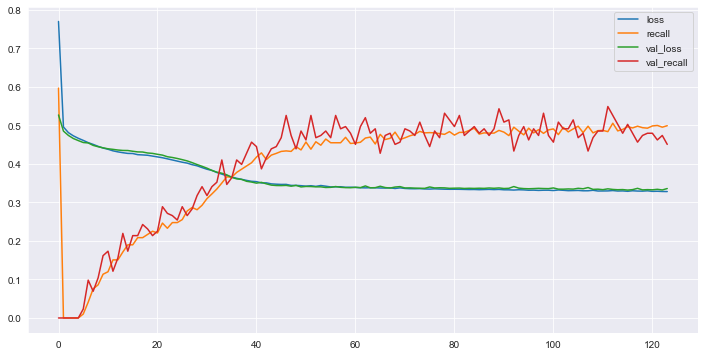

In [84]:
loss_df = pd.DataFrame(model.history.history) 
loss_df.plot()

In [85]:
y_pred = (model.predict(X_test) > .5).astype(
    "int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 2ms/step
[[1130   64]
 [ 155  151]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1194
           1       0.70      0.49      0.58       306

    accuracy                           0.85      1500
   macro avg       0.79      0.72      0.75      1500
weighted avg       0.84      0.85      0.84      1500



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

47/47 [==============================] - 0s 1ms/step


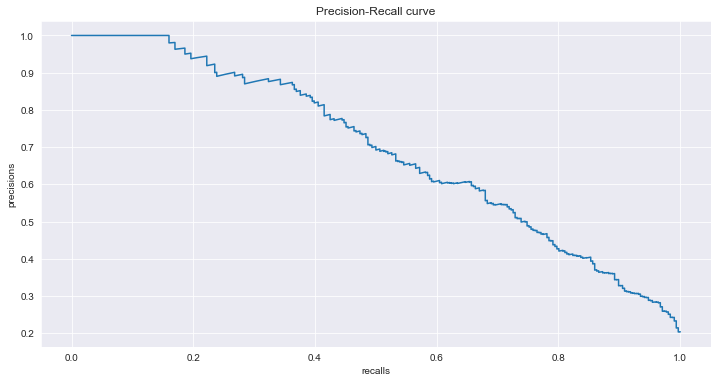

In [86]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [87]:
non_weighted_pre_score = average_precision_score(y_test, y_pred_proba)
non_weighted_pre_score

0.693132226386201

In [88]:
non_weighted_f1 = f1_score(y_test, y_pred)
non_weighted_recall = recall_score(y_test, y_pred)

### with class_weigth

In [89]:
tf.random.set_seed(42)

model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

In [90]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=10,
                           restore_best_weights = True)

In [91]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278726198292843, 1: 2.4550706033376124}

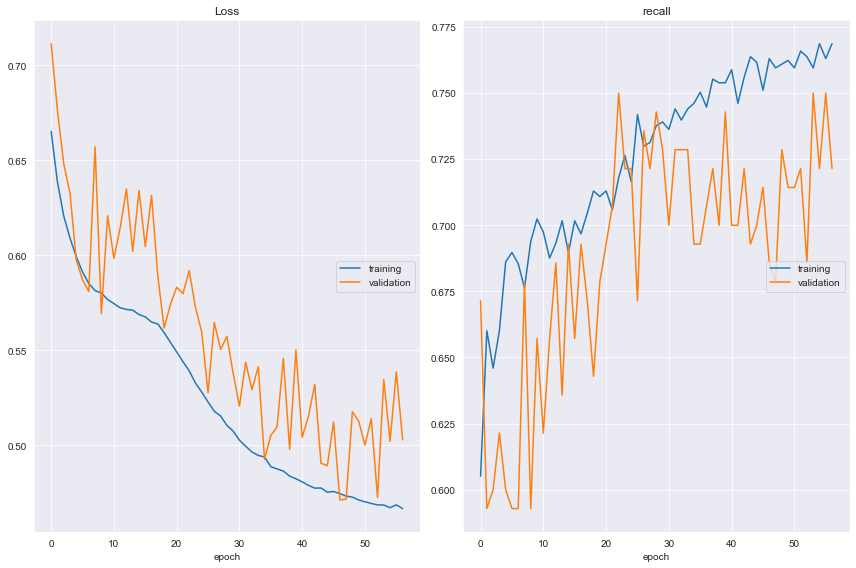

Loss
	training         	 (min:    0.467, max:    0.665, cur:    0.467)
	validation       	 (min:    0.471, max:    0.711, cur:    0.503)
recall
	training         	 (min:    0.605, max:    0.769, cur:    0.769)
	validation       	 (min:    0.593, max:    0.750, cur:    0.721)
54/54 [==============================] - 1s 11ms/step - loss: 0.4668 - recall: 0.7687 - val_loss: 0.5030 - val_recall: 0.7214
Epoch 57: early stopping


In [92]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop, PlotLossesKerasTF()],
          class_weight=class_weights)

<AxesSubplot:>

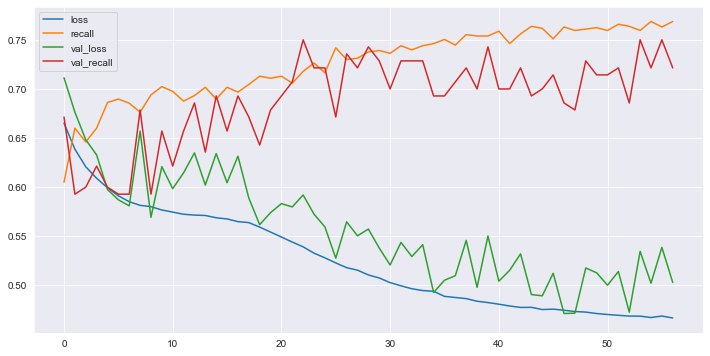

In [93]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [94]:
y_pred = (model.predict(X_test) > .5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 1ms/step
[[959 235]
 [ 93 213]]
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1194
           1       0.48      0.70      0.56       306

    accuracy                           0.78      1500
   macro avg       0.69      0.75      0.71      1500
weighted avg       0.82      0.78      0.80      1500



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

47/47 [==============================] - 0s 1ms/step


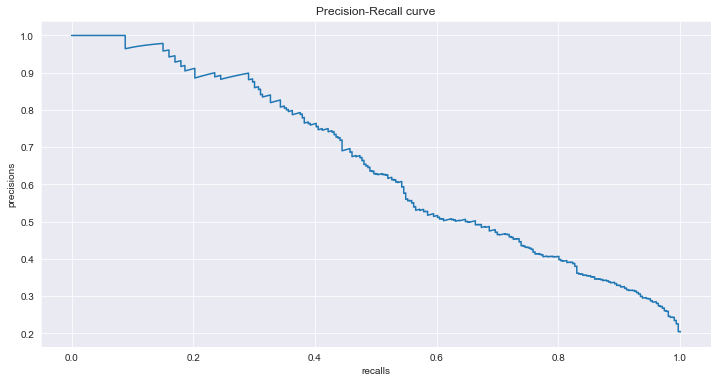

In [95]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [96]:
weighted_pre_score = average_precision_score(y_test, y_pred_proba)
weighted_pre_score  

0.6502465421233095

In [97]:
weighted_f1 = f1_score(y_test, y_pred)
weighted_recall = recall_score(y_test, y_pred)

## Optuna (Hyperparameter optimization tool)

In [98]:
import optuna
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam  

In [99]:
class_weights

{0: 0.6278726198292843, 1: 2.4550706033376124}

In [100]:
trial_metric = "Recall"
batch_size = 512


def create_model(trial):
    
    n_units1 = trial.suggest_int('n_units1', 8, 128)
    n_units2 = trial.suggest_int('n_units2', 8, 128)
    optimizer = trial.suggest_categorical("optimizer",
                                          [Adam, Adadelta, RMSprop, Nadam])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.3e-1)

    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_units1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(n_units2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer(learning_rate=learning_rate),
                  metrics=[trial_metric])
    return model


def objective(trial):
    model = create_model(trial)
    w0 = trial.suggest_loguniform("w0", 0.01, 5)
    w1 = trial.suggest_loguniform("w1", 0.01, 5)
    model.fit(X_train,
              y_train,
              validation_split=.1,
              batch_size=batch_size,
              epochs=100,
              callbacks=[early_stop],
              class_weight={0: w0, 1: w1},
              verbose=0)
    score = model.evaluate(X_test, y_test, verbose=0)[1]
    if score > .86 : 
        score = score * 0
    return score

In [101]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
study.best_params

[I 2023-01-20 20:30:22,527] A new study created in memory with name: no-name-dd94f03f-a915-4f9e-9786-fd18c15f2974


Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping


[I 2023-01-20 20:30:26,831] Trial 0 finished with value: 0.0 and parameters: {'n_units1': 25, 'n_units2': 48, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adadelta.Adadelta'>, 'learning_rate': 0.03897907943230546, 'w0': 0.4761536200573475, 'w1': 0.047909448556733354}. Best is trial 0 with value: 0.0.


Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


[I 2023-01-20 20:30:29,081] Trial 1 finished with value: 0.009803921915590763 and parameters: {'n_units1': 86, 'n_units2': 22, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adadelta.Adadelta'>, 'learning_rate': 1.2526601346318727e-05, 'w0': 0.09947693100448708, 'w1': 1.9809868158016484}. Best is trial 1 with value: 0.009803921915590763.


Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


[I 2023-01-20 20:30:32,310] Trial 2 finished with value: 0.0 and parameters: {'n_units1': 61, 'n_units2': 36, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.0015125863696377098, 'w0': 0.5360272941846734, 'w1': 0.06768673716403632}. Best is trial 1 with value: 0.009803921915590763.


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


[I 2023-01-20 20:30:36,169] Trial 3 finished with value: 0.0 and parameters: {'n_units1': 115, 'n_units2': 37, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adam.Adam'>, 'learning_rate': 0.03421113683660761, 'w0': 2.2929536418202265, 'w1': 0.019818845697660303}. Best is trial 1 with value: 0.009803921915590763.


Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping


[I 2023-01-20 20:30:40,605] Trial 4 finished with value: 0.5947712659835815 and parameters: {'n_units1': 78, 'n_units2': 20, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.04516403239027822, 'w0': 0.019832051560044903, 'w1': 0.061394237069026775}. Best is trial 4 with value: 0.5947712659835815.


Restoring model weights from the end of the best epoch: 26.
Epoch 36: early stopping


[I 2023-01-20 20:30:45,119] Trial 5 finished with value: 0.5032680034637451 and parameters: {'n_units1': 45, 'n_units2': 123, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adam.Adam'>, 'learning_rate': 0.003425891596888038, 'w0': 2.1666413034923875, 'w1': 3.421301890033572}. Best is trial 4 with value: 0.5947712659835815.
[I 2023-01-20 20:30:53,787] Trial 6 finished with value: 0.6372548937797546 and parameters: {'n_units1': 13, 'n_units2': 27, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adadelta.Adadelta'>, 'learning_rate': 2.5464662815736252e-05, 'w0': 1.327657241176569, 'w1': 0.015663695866702236}. Best is trial 6 with value: 0.6372548937797546.
[I 2023-01-20 20:31:02,263] Trial 7 finished with value: 0.019607843831181526 and parameters: {'n_units1': 43, 'n_units2': 57, 'optimizer': <class 'keras.optimizers.optimizer_experimental.rmsprop.RMSprop'>, 'learning_rate': 2.0224680583256047e-05, 'w0': 0.14774155041760131, 'w1': 0.35295443327030146}. Best is 

Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping


[I 2023-01-20 20:31:35,878] Trial 11 finished with value: 0.7026143670082092 and parameters: {'n_units1': 87, 'n_units2': 12, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.015642529875776953, 'w0': 0.01645680456633075, 'w1': 0.0733767674983318}. Best is trial 11 with value: 0.7026143670082092.


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping


[I 2023-01-20 20:31:39,937] Trial 12 finished with value: 0.5261437892913818 and parameters: {'n_units1': 102, 'n_units2': 9, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.010606760740422744, 'w0': 0.04496161607377962, 'w1': 0.09584442157439224}. Best is trial 11 with value: 0.7026143670082092.


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


[I 2023-01-20 20:31:44,433] Trial 13 finished with value: 0.4803921580314636 and parameters: {'n_units1': 92, 'n_units2': 91, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.12063433844278068, 'w0': 0.010210744203792742, 'w1': 0.030427671192289094}. Best is trial 11 with value: 0.7026143670082092.
[I 2023-01-20 20:31:53,878] Trial 14 finished with value: 0.12418300658464432 and parameters: {'n_units1': 125, 'n_units2': 35, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adadelta.Adadelta'>, 'learning_rate': 5.437012929400341e-05, 'w0': 0.06570508599960424, 'w1': 0.15067164797340094}. Best is trial 11 with value: 0.7026143670082092.


Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping


[I 2023-01-20 20:31:57,366] Trial 15 finished with value: 0.0 and parameters: {'n_units1': 72, 'n_units2': 82, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.00040761855389960544, 'w0': 4.315084486661282, 'w1': 0.02648268724903309}. Best is trial 11 with value: 0.7026143670082092.


Restoring model weights from the end of the best epoch: 53.
Epoch 63: early stopping


[I 2023-01-20 20:32:02,933] Trial 16 finished with value: 0.0 and parameters: {'n_units1': 20, 'n_units2': 8, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adam.Adam'>, 'learning_rate': 6.578817200885094e-05, 'w0': 0.6872535082314111, 'w1': 0.034582196204244194}. Best is trial 11 with value: 0.7026143670082092.


Restoring model weights from the end of the best epoch: 37.
Epoch 47: early stopping


[I 2023-01-20 20:32:07,176] Trial 17 finished with value: 0.4248366057872772 and parameters: {'n_units1': 27, 'n_units2': 31, 'optimizer': <class 'keras.optimizers.optimizer_experimental.rmsprop.RMSprop'>, 'learning_rate': 0.00643305716911079, 'w0': 0.2979708257704549, 'w1': 0.1409429814576619}. Best is trial 11 with value: 0.7026143670082092.
[I 2023-01-20 20:32:15,921] Trial 18 finished with value: 0.27124184370040894 and parameters: {'n_units1': 102, 'n_units2': 50, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adadelta.Adadelta'>, 'learning_rate': 0.0006891706573522743, 'w0': 0.044410736649398326, 'w1': 0.01472708532362759}. Best is trial 11 with value: 0.7026143670082092.


Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping


[I 2023-01-20 20:32:18,584] Trial 19 finished with value: 0.0 and parameters: {'n_units1': 65, 'n_units2': 77, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.0011882374235163051, 'w0': 0.9702397971073445, 'w1': 0.04715143772510204}. Best is trial 11 with value: 0.7026143670082092.
[I 2023-01-20 20:32:26,643] Trial 20 finished with value: 0.1111111119389534 and parameters: {'n_units1': 35, 'n_units2': 26, 'optimizer': <class 'keras.optimizers.optimizer_experimental.adadelta.Adadelta'>, 'learning_rate': 0.000181088401639406, 'w0': 0.13223245806681383, 'w1': 0.012505813227098296}. Best is trial 11 with value: 0.7026143670082092.


Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping


[I 2023-01-20 20:32:31,281] Trial 21 finished with value: 0.7875816822052002 and parameters: {'n_units1': 77, 'n_units2': 17, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.007250098135330061, 'w0': 0.010168379056579791, 'w1': 0.07934873633243503}. Best is trial 21 with value: 0.7875816822052002.


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping


[I 2023-01-20 20:32:34,932] Trial 22 finished with value: 0.7516340017318726 and parameters: {'n_units1': 87, 'n_units2': 9, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.009513727111149242, 'w0': 0.014421535079858905, 'w1': 0.08307563319181052}. Best is trial 21 with value: 0.7875816822052002.


Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping


[I 2023-01-20 20:32:39,170] Trial 23 finished with value: 0.7908496856689453 and parameters: {'n_units1': 86, 'n_units2': 10, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.010646194198258456, 'w0': 0.013918648900591394, 'w1': 0.10774931519404361}. Best is trial 23 with value: 0.7908496856689453.


Restoring model weights from the end of the best epoch: 48.
Epoch 58: early stopping


[I 2023-01-20 20:32:45,990] Trial 24 finished with value: 0.8202614188194275 and parameters: {'n_units1': 98, 'n_units2': 44, 'optimizer': <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>, 'learning_rate': 0.004540132932243887, 'w0': 0.012666852827280625, 'w1': 0.21201826019923642}. Best is trial 24 with value: 0.8202614188194275.


{'n_units1': 98,
 'n_units2': 44,
 'optimizer': keras.optimizers.optimizer_experimental.nadam.Nadam,
 'learning_rate': 0.004540132932243887,
 'w0': 0.012666852827280625,
 'w1': 0.21201826019923642}

In [102]:
unit1, unit2, optimizer, lr, w0, w1 = (study.best_params['n_units1'],
                               study.best_params['n_units2'],
                               study.best_params['optimizer'],
                               study.best_params['learning_rate'], 
                               study.best_params['w0'],
                               study.best_params['w1'] )
tf.random.set_seed(42)
model = Sequential()
model.add(Dense(unit1, activation="relu"))
model.add(Dense(unit2, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
opt = optimizer(lr=lr)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["Recall"])


model.fit(X_train,
          y_train,
          validation_split=.1,
          batch_size=512,
          epochs=100,
          callbacks=[early_stop],
          class_weight={0: w0, 1: w1},
          verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 22ms/step - loss: 0.0306 - recall: 0.9880 - val_loss: 1.0634 - val_recall: 1.0000
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 0.0261 - recall: 1.0000 - val_loss: 1.3970 - val_recall: 1.0000
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 0.0252 - recall: 1.0000 - val_loss: 1.3731 - val_recall: 1.0000
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 0.0246 - recall: 1.0000 - val_loss: 1.2605 - val_recall: 1.0000
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0241 - recall: 1.0000 - val_loss: 1.2675 - val_recall: 1.0000
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0238 - recall: 1.0000 - val_loss: 1.2648 - val_recall: 1.0000
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.0235 - recall: 0.9993 - val_loss: 1.2503 - val_recall: 0.9929
Epoch 8/100
14/14 [=====================

In [103]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 1ms/step
[[   0 1194]
 [   0  306]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1194
           1       0.20      1.00      0.34       306

    accuracy                           0.20      1500
   macro avg       0.10      0.50      0.17      1500
weighted avg       0.04      0.20      0.07      1500



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

47/47 [==============================] - 0s 1ms/step


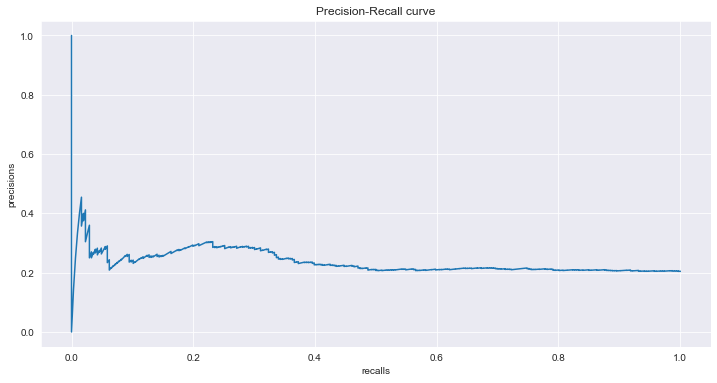

In [104]:
y_pred_proba = model.predict(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [105]:
optuna_pre_score = average_precision_score(y_test, y_pred_proba)
optuna_pre_score  

0.23654741884267955

In [106]:
optuna_weighted_f1 = f1_score(y_test, y_pred)
optuna_weighted_recall = recall_score(y_test, y_pred)

## Model Comparission

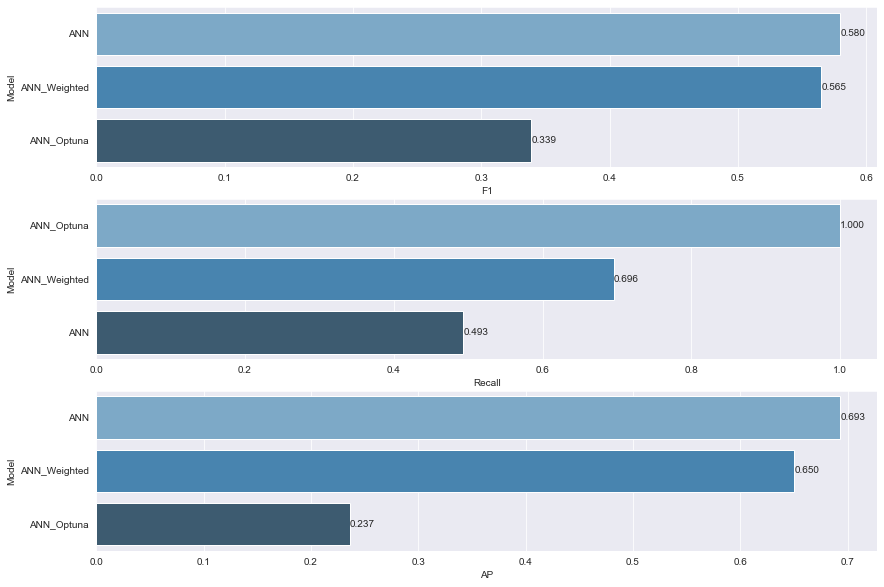

In [107]:
compare = pd.DataFrame({
    "Model": ["ANN", "ANN_Weighted", "ANN_Optuna"],
    "F1": [non_weighted_f1, weighted_f1, optuna_weighted_f1],
    "Recall": [non_weighted_recall, weighted_recall, optuna_weighted_recall],
    "AP": [non_weighted_pre_score, weighted_pre_score, optuna_pre_score]
})


def labels(ax):
    for p in ax.patches:
        width = p.get_width() 
        ax.text(
            width,  
            p.get_y() +
            p.get_height() / 2,  
            '{:1.3f}'.format(width), 
            ha='left',  
            va='center')  


plt.figure(figsize=(14, 10))
plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax = sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax = sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(313)
compare = compare.sort_values(by="AP", ascending=False)
ax = sns.barplot(x="AP", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

## Final Model and Model Deployment

In [108]:
import pickle 

pickle.dump(col_transformer, open("transformer_churn", "wb"))
pickle.dump(scaler, open("scaler_churn", 'wb'))


In [109]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.15,
                                                    random_state=42)

In [111]:
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

In [112]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [113]:
study.best_params

{'n_units1': 98,
 'n_units2': 44,
 'optimizer': keras.optimizers.optimizer_experimental.nadam.Nadam,
 'learning_rate': 0.004540132932243887,
 'w0': 0.012666852827280625,
 'w1': 0.21201826019923642}

* balanced
- 'n_units1': 38,
- 'n_units2': 67,
- 'optimizer': keras.optimizer_v2.adam.Adam,
- 'learning_rate': 0.0021431406414847
- 'class_weight' : balanced
* best recall
- ''n_units1': 84,
- 'n_units2': 91,
- 'optimizer': keras.optimizer_v2.nadam.Nadam,
- 'learning_rate': 0.02042786100335945,
- 'w0': 0.03567341869069141,
- 'w1': 0.4176819267630142

In [114]:
tf.random.set_seed(42)
model = Sequential()

model.add(Dense(84, activation="relu"))
model.add(Dense(91, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Nadam(learning_rate=0.02042786100335945),
              loss="binary_crossentropy",
              metrics=["Recall"])

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          callbacks=[early_stop],
          batch_size=512,
          epochs=150,
          verbose=1,
          class_weight={0:0.03567341869069141, 1:0.4176819267630142})

Epoch 1/150
17/17 [==============================] - 2s 18ms/step - loss: 0.0611 - recall: 0.9601 - val_loss: 0.8021 - val_recall: 0.9183
Epoch 2/150
17/17 [==============================] - 0s 6ms/step - loss: 0.0556 - recall: 0.9723 - val_loss: 0.9064 - val_recall: 0.9314
Epoch 3/150
17/17 [==============================] - 0s 6ms/step - loss: 0.0511 - recall: 0.9341 - val_loss: 0.7074 - val_recall: 0.8725
Epoch 4/150
17/17 [==============================] - 0s 6ms/step - loss: 0.0469 - recall: 0.9278 - val_loss: 0.6418 - val_recall: 0.8464
Epoch 5/150
17/17 [==============================] - 0s 6ms/step - loss: 0.0461 - recall: 0.9220 - val_loss: 0.8401 - val_recall: 0.9379
Epoch 6/150
17/17 [==============================] - 0s 6ms/step - loss: 0.0451 - recall: 0.9347 - val_loss: 0.8086 - val_recall: 0.9379
Epoch 7/150
17/17 [==============================] - 0s 5ms/step - loss: 0.0448 - recall: 0.9289 - val_loss: 0.7817 - val_recall: 0.9150
Epoch 8/150
17/17 [=====================

<AxesSubplot:>

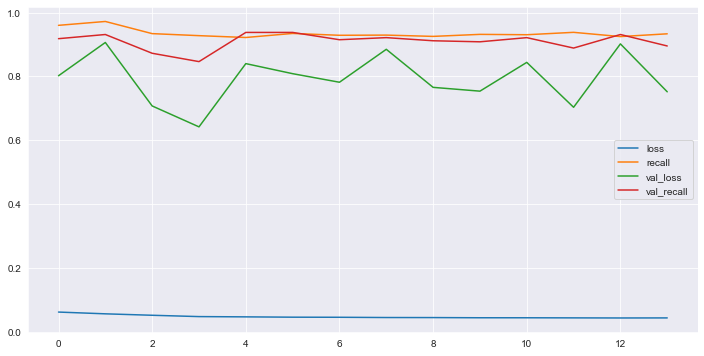

In [115]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [116]:
y_pred = (model.predict(X_test) > .5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

47/47 [==============================] - 0s 1ms/step
[[745 449]
 [ 47 259]]
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1194
           1       0.37      0.85      0.51       306

    accuracy                           0.67      1500
   macro avg       0.65      0.74      0.63      1500
weighted avg       0.82      0.67      0.70      1500



In [117]:
model.save('model_churn.h5')

### Prediction

In [118]:
single_customer = df.drop('Exited', axis=1).iloc[[0]]
single_customer

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,customer_value,EstimatedSalary
0,1,619,France,Female,42,2,0.0,1,1,1,3,101348.9


In [119]:
single_customer1 = single_customer.copy()
single_customer1["Geography"] = "Spain"
single_customer1["Age"] = 35
single_customer1["Balance"] = 200000

In [120]:
single_customer1 = col_transformer.transform(single_customer1)
single_customer1

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 6.1900000e+02, 3.5000000e+01,
        2.0000000e+00, 2.0000000e+05, 1.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 3.0000000e+00, 1.0134888e+05]])

In [121]:
single_customer1 = scaler.transform(single_customer1)
single_customer1

array([[0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.538     , 0.22972973, 0.2       , 0.83896995,
        0.        , 1.        , 1.        , 0.5       , 0.50673489]])

In [122]:
model.predict(single_customer1)

1/1 [==============================] - 0s 30ms/step


array([[0.4651459]], dtype=float32)

In [123]:
(model.predict(single_customer1) > 0.5).astype("int32")

1/1 [==============================] - 0s 23ms/step


array([[0]])

## Comparison with ML

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [125]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.15,
                                                    random_state=42)

In [127]:
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

In [128]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [129]:
clf1 = RandomForestClassifier(random_state=42, class_weight="balanced")
clf2 = SVC(probability=True, random_state=42, class_weight="balanced")
clf3 = LogisticRegression(random_state=42, class_weight="balanced")

In [130]:

param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**(-2 + i) for i in range(5)]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**(-2 + i) for i in range(5)]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

In [131]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3] 

In [132]:
grid_model = RandomizedSearchCV(pipeline,
                                params,
                                cv=5,
                                n_jobs=-1,
                                scoring='recall').fit(X_train, y_train)

In [133]:
grid_model.best_params_ 

{'classifier__n_estimators': 50,
 'classifier__max_depth': 5,
 'classifier': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50,
                        random_state=42)}

In [134]:
grid_model.best_score_ 

0.7417817460978494

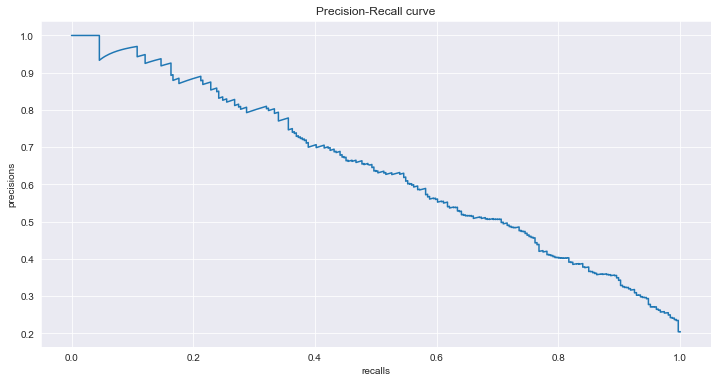

In [135]:
y_pred_proba = grid_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='RF')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [136]:
average_precision_score(y_test, y_pred_proba)

0.641919116902083

In [137]:
y_pred = grid_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[957 237]
 [ 84 222]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1194
           1       0.48      0.73      0.58       306

    accuracy                           0.79      1500
   macro avg       0.70      0.76      0.72      1500
weighted avg       0.83      0.79      0.80      1500

